# Neural Signal Processing

*Originally written by Luke Chang*
*Adapted by Tom Yeh*

In this lab we learn the basics of convolution, sine waves, and fourier transforms. This lab is largely based on exercises from Mike X Cohen's excellent book, [Analying Neural Data Analysis: Theory and Practice](https://www.amazon.com/Analyzing-Neural-Time-Data-Practice/dp/0262019876). If you are interested in learning in more detail about the basics of EEG and time-series analyses I highly recommend his accessible introduction. I also encourage you to watch his accompanying freely available [*lecturelets*](http://mikexcohen.com/lectures.html) to learn more about each topic introduced in this notebook.


* dot product
* convolution
* oscillations
* time domain versus frequency domain
* high-pass
* low-pass
* band-stop


In [1]:
%matplotlib inline

import numpy as np
from numpy import sin, pi, arange

import matplotlib.pyplot as plt
from ipywidgets import interact_manual, interact

# Using Interactive Widgets

Let's begin by creating a vector to represent a signal of 20 samples of random values.

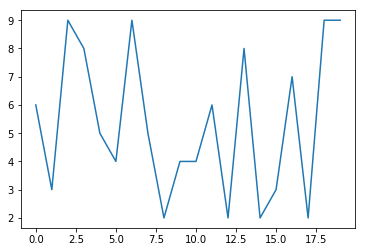

In [2]:
a = np.random.randint(1,10,20)
plt.plot(a)

We can rewrite the code above into a function and introduce a parameter to control how many samples to create.

In [3]:
def create_random_signal(n_samples):
    return np.random.randint(1,10,n_samples)
    

Often we want to understand how the signal may look differently with different parameter values. It is possible to create a slider widget to enable interactive exploration.

In [4]:
@interact_manual(n_samples = 20)
def test_create_random_signal(n_samples):
    signal = create_random_signal(n_samples)
    plt.plot(signal)


interactive(children=(IntSlider(value=20, description='n_samples', max=60, min=-20), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

### Exercises

Now, it's your turn to practice using `@interactive_manual`. 

The code below creates two random signals and shows them in two rows of subplots.

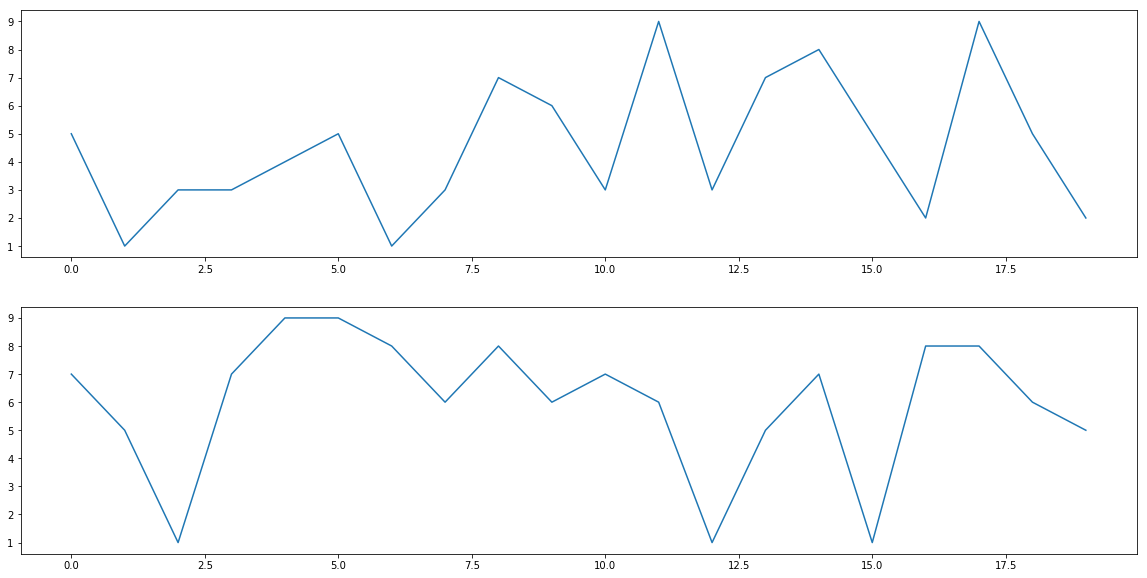

In [9]:
a = np.random.randint(1,10,20)
b = np.random.randint(1,10,20)

f,s = plt.subplots(nrows=2, figsize=(20,10))
s[0].plot(a)
s[1].plot(b)

Your task is to introduce two parameters---`n_samples` and `n_signals` so that we can use two sliders to control their values in order to view any number of signals (rows) and any number of samples in each signal. You will put your code between the `BEGIN SOLUTION` and `END SOLUTION` tags.

In [6]:
@interact_manual(n_samples = 20, n_signals = 5)
def test_create_random_signal(n_samples, n_signals):
    ### BEGIN SOLUTION
    signals = []
    for i in range (0,n_signals):
        signals.append(np.random.randint(1,10,n_samples))
    
    f,s = plt.subplots(nrows=n_signals, figsize=(20,10))
    
    for j in range (0,n_signals):
        s[j].plot(signals[j])
    
    
    
    ### END SOLUTION

interactive(children=(IntSlider(value=20, description='n_samples', max=60, min=-20), IntSlider(value=5, description='n_signals', max=15, min=-5), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# Time Domain

First we will work on signals in the time domain.  This requires measuring a signal at a constant interval over time.  The frequency with which we measure a signal is referred to as the sampling frequency.  The units of this are typically described in $Hz$ - or the number of cycles per second. It is critical that the sampling frequency is consistent over the entire measurement of the time series.

## Dot Product
To understand convolution, we first need to familiarize ourselves with the dot product.  The dot product is simply the sum of the elements of a vector weighted by the elements of another vector. This method is commonly used in signal processing, and also in statistics as a measure of similarity between two vectors. Finally, there is also a geometric inrepretation which is a mapping between vectors (i.e., the product of the magnitudes of the two vectors scaled by the cosine of the angle between them). For a more in depth overview of the dot product and its relation to convolution see this [video](http://mikexcohen.com/lecturelets/dotproduct/dotproduct.html)

$dotproduct_{ab}=\sum\limits_{i=1}^n a_i b_i$

Let's create some vectors of random numbers and see how the dot product works.  First, the two vectos need to be of the same length.

Dot Product: 530


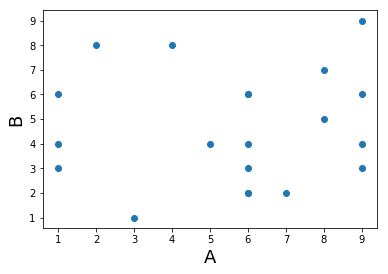

In [14]:
a = np.random.randint(1,10,20)
b = np.random.randint(1,10,20)

plt.scatter(a,b)
plt.ylabel('B', fontsize=18)
plt.xlabel('A', fontsize=18)

print('Dot Product: %s' % np.dot(a,b))

what happens when we make the two variables more similar?  In the next example we add gaussian noise on top of one of the vectors.  

Dot Product: 566.6873763306883


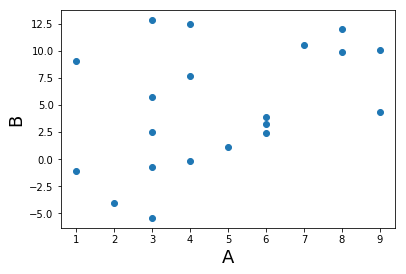

In [15]:
a = np.random.randint(1,10,20)

noise = np.random.randn(20)
noise_size = 5
b = a +  noise * noise_size

plt.scatter(a,b)
plt.ylabel('B', fontsize=18)
plt.xlabel('A', fontsize=18)

print('Dot Product: %s' % np.dot(a,b))

### Exercise

As two vectors are becoming more different, does the dot product between them increase or decrease? To answer the question, implement the function `test_dot_product` to allow someone to interactively explore how changing the values of `noise_size` and `n_samples` may affect the dot product value.

In [5]:
@interact_manual(noise_size = 2, n_samples = 100)
def test_dot_product(noise_size, n_samples):
    ### BEGIN SOLUTION
    a = np.random.randint(1,10,n_samples)

    noise = np.random.randn(n_samples)
    b = a +  noise * noise_size

    plt.scatter(a,b)
    plt.ylabel('B', fontsize=18)
    plt.xlabel('A', fontsize=18)

    ### END SOLUTION
    print('Dot Product: %s' % np.dot(a,b))

interactive(children=(IntSlider(value=2, description='noise_size', max=6, min=-2), IntSlider(value=100, description='n_samples', max=300, min=-100), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

Using the interactive cell you just created, answer the following questions:
    
Q. Given a fixed `n_samples`, does more noise increase or decrease the dot product value?

A. increase

Q. Given a fixed `noise_size`, does more samples increase or decrease the dot product value?

A. increase

## Convolution
Convolution in the time domain is an extension of the dot product in which the dot product is computed iteratively over time.  One way to think about it is that one signal weights each time point of the other signal and then slides forward over time.  Let's call the timeseries variable *signal* and the other vector the *kernel*. Importantly, for our purposes the kernel will almost always be smaller than the signal, otherwise we would only have one scalar value afterwards.

To gain an intuition of how convolution works, let's play with some data. First, let's create a time series of spikes. Then let's convolve this signal with a boxcar kernel.

In [8]:
def create_spikes(n_samples, n_spikes):

    signal = np.zeros(n_samples)
    signal[np.random.randint(0,n_samples,n_spikes)] = 1
    
    return signal

def create_boxcar_kernel(width):
    kernel = np.zeros(width+4)
    kernel[2:2+width] = 1
    
    return kernel

In [10]:
@interact_manual(n_samples=100, n_spikes=5)
def test_create_spikes(n_samples, n_spikes):    
    signal = create_spikes(n_samples, n_spikes)    
    plt.plot(signal)

interactive(children=(IntSlider(value=100, description='n_samples', max=300, min=-100), IntSlider(value=5, description='n_spikes', max=15, min=-5), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [12]:
@interact_manual(width=6)
def test_create_boxcar_kernel(width):    
    kernel = create_boxcar_kernel(width)    
    plt.plot(kernel)

interactive(children=(IntSlider(value=6, description='width', max=18, min=-6), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

Let's create a signal with 100 sampkles and 5 spikes.

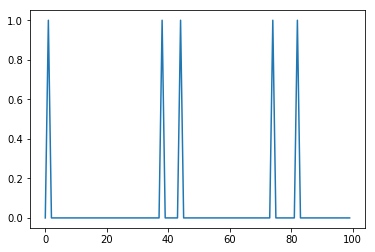

In [14]:
signal = create_spikes(100, 5)
plt.plot(signal)

Let's create a kernel.

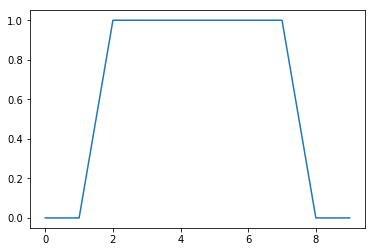

In [15]:
kernel = create_boxcar_kernel(6)
plt.plot(kernel)

Notice how the kernel is only 10 samples long and the boxcar width is about 6 seconds, while the signal is 100 samples long with 5 single pulses.

Now let's convolve the signal with the kernel by taking the dot product of the kernel with each time point of the signal. This can be illustrated by creating a matrix of the kernel shifted each time point of the signal.

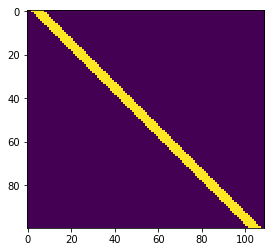

In [16]:
n_samples = 100
shifted_kernel = np.zeros((n_samples, n_samples+len(kernel) - 1))
for i in range(n_samples):
    shifted_kernel[i, i:i+len(kernel)] = kernel

plt.imshow(shifted_kernel)

Now, let's take the dot product of the signal with this matrix. To refresh your memory from basic linear algebra. Matrix multiplication consists of taking the dot product of the signal vector with each row of this expanded kernel matrix.  

Text(0.5,0,'Time')

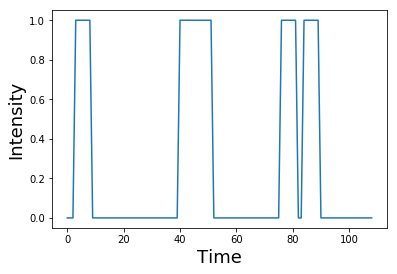

In [17]:
convolved_signal = np.dot(signal, shifted_kernel)

plt.plot(convolved_signal)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

You can see that after convolution, each spike has now become the shape of the kernel. Spikes that were closer in time compound if the boxes overlap.

Notice also how the shape of the final signal is the length of the combined signal and kernel minus one.

In [18]:
print("Signal Length: %s" % len(signal))
print("Kernel Length: %s" % len(kernel))
print("Convolved Signal Length: %s" % len(convolved_signal))

Signal Length: 100
Kernel Length: 10
Convolved Signal Length: 109


this process of iteratively taking the dot product of the kernel with each timepoint of the signal and summing all of the values can be performed by using the convolution function from numpy `np.convolve`

Text(0.5,0,'Time')

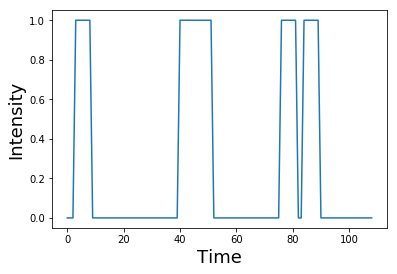

In [19]:
plt.plot(np.convolve(signal, kernel))
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

What happens if the spikes have different intensities, reflected by different heights?

Text(0.5,0,'Time')

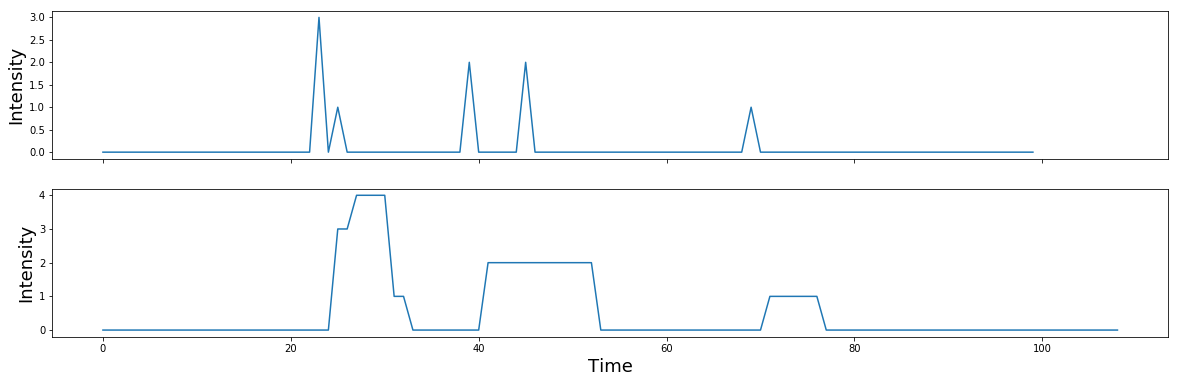

In [21]:
signal = np.zeros(n_samples)
signal[np.random.randint(0,n_samples,5)] = np.random.randint(1,5,5)

f,a = plt.subplots(nrows=2, figsize=(20,6), sharex=True)
a[0].plot(signal)
a[0].set_ylabel('Intensity', fontsize=18)
a[1].plot(np.convolve(signal, kernel))
a[1].set_ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

Let's rewrite the code above as a function and use @interact_manual to allow interactive exploration of how the different parameters affect the convolution results.

In [22]:
def create_spikes_with_random_heights(n_samples, n_spikes, intensity):
    signal = np.zeros(n_samples)
    signal[np.random.randint(0,n_samples,n_spikes)] = np.random.randint(1, intensity, n_spikes)
    return signal

In [23]:
@interact_manual(n_samples = 100, n_spikes = 5, intensity = 5)
def test_create_spikes_with_random_heights(n_samples, n_spikes, intensity):
    signal = create_spikes_with_random_heights(n_samples, n_spikes, intensity)
    f,a = plt.subplots(nrows=2, figsize=(20,6), sharex=True)
    a[0].plot(signal)
    a[0].set_ylabel('Intensity', fontsize=18)
    a[1].plot(np.convolve(signal, kernel))
    a[1].set_ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)

interactive(children=(IntSlider(value=100, description='n_samples', max=300, min=-100), IntSlider(value=5, description='n_spikes', max=15, min=-5), IntSlider(value=5, description='intensity', max=15, min=-5), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## HRF

Now what happens if we switch out the boxcar kernel for something with a more interesting shape, say a hemodynamic response function?  Here we will use a double gamma hemodynamic function (HRF) developed by Gary Glover. 

**Note**: If you haven't install nltools yet run `!pip install nltools`.  You may need to restart your jupyter kernel as well.

Text(0.5,0,'Time')

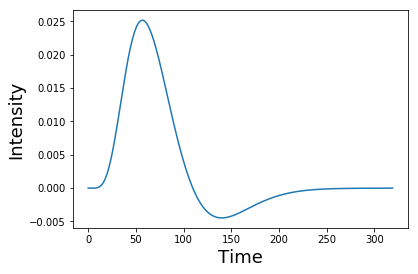

In [26]:
#!pip install nltools
from nltools.external import glover_hrf

tr = 2
hrf = glover_hrf(tr, oversampling=20)
plt.plot(hrf)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

For this example, we oversampled the function to make it more smooth.  In practice we will want to make sure that the kernel is the correct shape given our sampling resolution.  Be sure to se the oversampling to 1.  Notice how the function looks more jagged now?

Text(0.5,0,'Time')

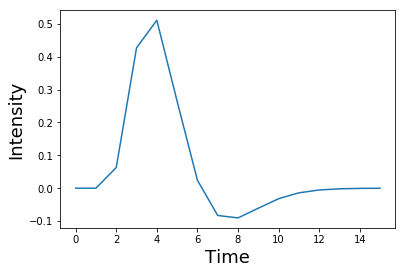

In [27]:
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

Now let's try convolving our event pulses with this HRF kernel.

Text(0.5,0,'Time')

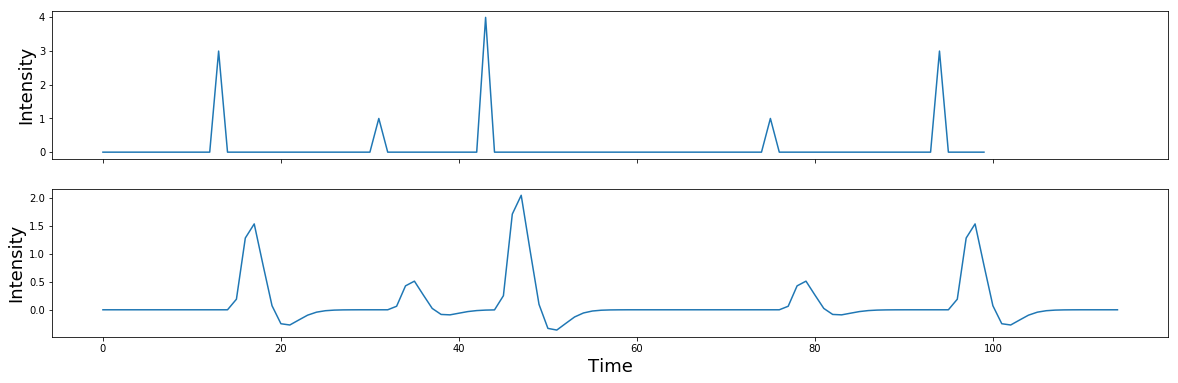

In [28]:
signal = np.zeros(n_samples)
signal[np.random.randint(0,n_samples,5)] = np.random.randint(1,5,5)

f,a = plt.subplots(nrows=2, figsize=(20,6), sharex=True)
a[0].plot(signal)
a[1].plot(np.convolve(signal, hrf))
a[0].set_ylabel('Intensity', fontsize=18)
a[1].set_ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

If you are interested in a more detailed overview of convolution and the HRF function, I encourage you to read this excellent [overview](https://practical-neuroimaging.github.io/on_convolution.html) using python examples. 

### Exercise

Implement a function to explore the effect of changing the value of `oversampling` on the shape of the HRF kernel returned by `glover_hrf`.

In [29]:
@interact_manual(oversampling=1)
def test_glover_hrf(oversampling):
    ### BEGIN SOLUTION
    hrf = glover_hrf(tr, oversampling=oversampling)
#     plt.plot(hrf)
#     plt.ylabel('Intensity', fontsize=18)
#     plt.xlabel('Time', fontsize=18)

    signal = np.zeros(n_samples)
    signal[np.random.randint(0,n_samples,5)] = np.random.randint(1,5,5)

    f,a = plt.subplots(nrows=2, figsize=(20,6), sharex=True)
    a[0].plot(signal)
    a[1].plot(np.convolve(signal, hrf))
    a[0].set_ylabel('Intensity', fontsize=18)
    a[1].set_ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    
    ### END SOLUTION
    return None

interactive(children=(IntSlider(value=1, description='oversampling', max=3, min=-1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Oscillations

Ok, now let's move on to studying time-varying signals that have the shape of oscillating waves.

Oscillations can be described mathematically as:

$A\sin(2 \pi ft + \theta)$

where $f$ is the frequency or the speed of the oscillation described in the number of cycles per second - $Hz$. Amplitude $A$ refers to the height of the waves, which is half the distance of the peak to the trough. Finally, $\theta$ describes the phase angle offset, which is in radians.

Check out this short [video](http://mikexcohen.com/lecturelets/sinewave/sinewave.html) for a more in depth explanation of sine waves.

Here we will plot a simple sine wave.  Try playing with the different parameters (i.e., amplitude, frequency, & theta) to gain an intuition of how they each impact the shape of the wave.

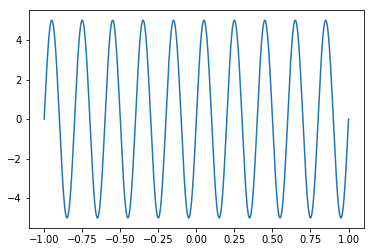

In [30]:
from numpy import sin, pi, arange

sampling_freq = 1000
time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq)
amplitude = 5
freq = 5
theta = 0

simulation = amplitude * sin(2 * pi * freq * time + theta)
plt.plot(time, simulation)

### Exercise

Implement an interactive function to explore the shape of sine waves in relation to four parameters: `sampling_freq`, `fre`, `theta` and `amplitude`.

In [32]:
@interact(sampling_freq = 100, freq = 5, theta = 2, amplitude = 5)
def test_sine_waves(sampling_freq, freq, theta, amplitude):
    ### BEGIN SOLUTION
    sampling_freq = sampling_freq
    time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq)
    amplitude = amplitude
    freq = freq
    theta = theta

    simulation = amplitude * sin(2 * pi * freq * time + theta)
    plt.plot(time, simulation)
    ### END SOLUTION    

interactive(children=(IntSlider(value=100, description='sampling_freq', max=300, min=-100), IntSlider(value=5, description='freq', max=15, min=-5), IntSlider(value=2, description='theta', max=6, min=-2), IntSlider(value=5, description='amplitude', max=15, min=-5), Output()), _dom_classes=('widget-interact',))

## Simulation  

Next we will generate a simulation combining multiple sine waves oscillating at different frequencies. 

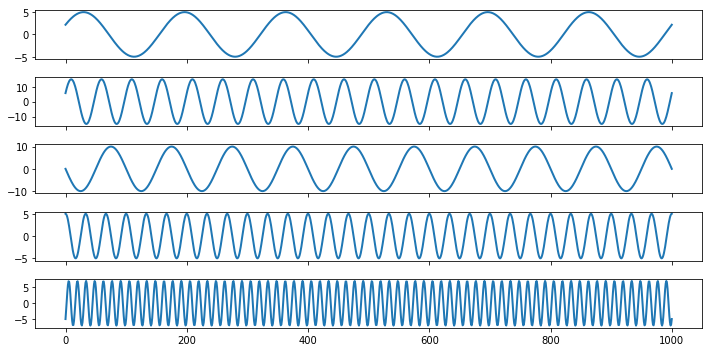

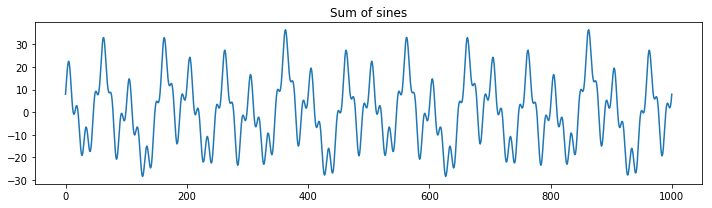

In [46]:
sampling_freq = 500

freq = [3, 10, 5 ,15, 35]
amplitude = [5, 15, 10, 5, 7]
phases = pi*np.array([1/7, 1/8, 1, 1/2, -1/4])

time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq) 

sine_waves = []
for i,f in enumerate(freq):
    sine_waves.append(amplitude[i] * sin(2*pi*f*time + phases[i]))
sine_waves = np.array(sine_waves)


f,a = plt.subplots(nrows=5, ncols=1, figsize=(10,5), sharex=True)
for i,x in enumerate(freq):
    a[i].plot(sine_waves[i,:], linewidth=2)
plt.tight_layout()    


plt.figure(figsize=(10,3))
plt.plot(np.sum(sine_waves, axis=0))
plt.title("Sum of sines")
plt.tight_layout()    


What is the effect of changing the sampling frequency on our ability to measure these oscillations?  Try dropping it to be very low (e.g., less than 70 hz.)  Notice that signals will alias when the sampling frequency is below the nyquist frequency of a signal. To observe the oscillations, we need to be sampling at least two times the speed of the oscillation. This will result in a jagged view of the data, but we can still accurately observe the frequency.  Higher sampling rates allow us to better observe the underlying signals.

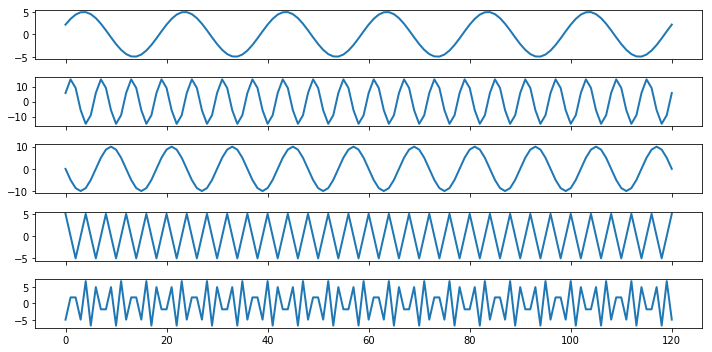

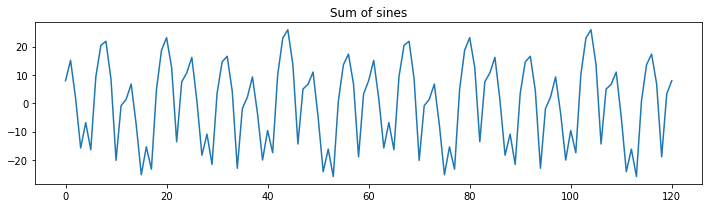

In [47]:
sampling_freq = 60

freq = [3, 10, 5 ,15, 35]
amplitude = [5, 15, 10, 5, 7]
phases = pi*np.array([1/7, 1/8, 1, 1/2, -1/4])

time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq) 

sine_waves = []
for i,f in enumerate(freq):
    sine_waves.append(amplitude[i] * sin(2*pi*f*time + phases[i]))
sine_waves = np.array(sine_waves)


f,a = plt.subplots(nrows=5, ncols=1, figsize=(10,5), sharex=True)
for i,x in enumerate(freq):
    a[i].plot(sine_waves[i,:], linewidth=2)
plt.tight_layout()    


plt.figure(figsize=(10,3))
plt.plot(np.sum(sine_waves, axis=0))
plt.title("Sum of sines")
plt.tight_layout()    


Be sure to rerun the code after increasing the sampling frequency above 70hz.

We can add a little bit of gaussian (white) noise on top of this signal to make it even more realistic.  Try varying the amount of noise by adjusting the scaling on the noise.

shape[1]:
121


Text(0.5,0,'Time')

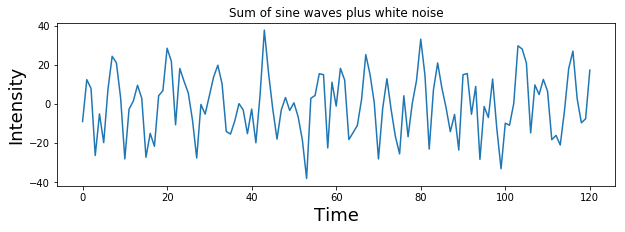

In [51]:
noise = 8 * np.random.randn(sine_waves.shape[1]) 
print("shape[1]:")
print(sine_waves.shape[1])
signal = np.sum(sine_waves,axis=0) + noise

plt.figure(figsize=(10,3))
plt.plot( signal )
plt.title("Sum of sine waves plus white noise")
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

### Exercise

Let's refactor the code above. Implement a function that can generate a signal by combining multiple sine waves and adding noise.

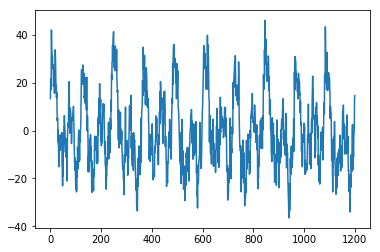

In [57]:
def generate_signal(sampling_freq, freq, amplitude, phases):
    ### BEGIN SOLUTION
    sampling_freq = sampling_freq

    freq = freq
    amplitude = amplitude
    phases = phases

    time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq) 

    sine_waves = []
    for i,f in enumerate(freq):
        sine_waves.append(amplitude[i] * sin(2*pi*f*time + phases[i])) 
    sine_waves = np.array(sine_waves)


#     f,a = plt.subplots(nrows=5, ncols=1, figsize=(10,5), sharex=True)
#     for i,x in enumerate(freq):
#         a[i].plot(sine_waves[i,:], linewidth=2)
#     plt.tight_layout()  

    noise = 5 * np.random.randn(sine_waves.shape[1]) 
    
    ### END SOLUTION
    return (np.sum(sine_waves, axis=0) + noise)
    
def plot_signal(signal):    
    plt.plot(signal)
    
    
signal = generate_signal(600, [3, 10, 5, 15, 35], [5, 15, 10, 5, 7], [1/7, 1/8, 1, 1/2, -1/4])
plot_signal(signal)

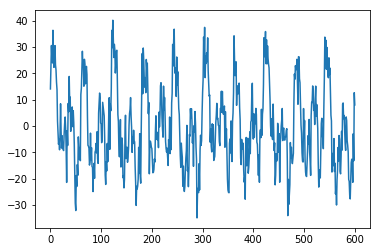

In [58]:
# Test Case
signal = generate_signal(300, [3, 10, 5, 15, 35], [5, 15, 10, 5, 7], [1/7, 1/8, 1, 1/2, -1/4])
plot_signal(signal)

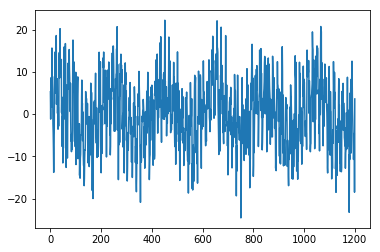

In [59]:
# Test Case
signal = generate_signal(600, [3, 35], [5, 7], [1/7, -1/4])
plot_signal(signal)